# IBM Capstone Project: The Battle of the Neighborhoods


## download and explore the dataset

Import libraries

In [1]:
#install libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap
from bs4 import BeautifulSoup # main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
print('Libraries imported.')

Libraries imported.


### Get geocoordinates of Milan, Italy

In [3]:
Milan_address = 'Milan, Italy'

geolocator = Nominatim(user_agent="milan_explorer")
location = geolocator.geocode(Milan_address)
latitude = location.latitude
longitude = location.longitude
milan_center = [latitude, longitude]
print('The geograpical coordinate of {} are {}, {}.'.format(Milan_address, latitude, longitude))

The geograpical coordinate of Milan, Italy are 45.4668, 9.1905.


### Get neighborhood data of Milan

In [4]:
url = "https://en.wikipedia.org/wiki/Category:Districts_of_Milan"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace('(district of Milan)', '').replace(', Milan', '').replace('(district)','').replace('(Milan)',''))
    
neighborhoodList    

['Affori',
 'Assiano',
 'Baggio ',
 'Barona',
 'Bicocca ',
 'Bovisa',
 'Bovisasca',
 'Brera ',
 'Bruzzano',
 'Calvairate',
 'Centro Direzionale di Milano',
 'Chiaravalle ',
 'Chinatown',
 'Cimiano',
 'Città Studi',
 'Comasina',
 'Conca del Naviglio',
 'Crescenzago',
 'Dergano',
 'Figino ',
 'Forlanini ',
 'Gallaratese',
 'Garegnano',
 'Ghisolfa',
 'Giambellino-Lorenteggio',
 'Gorla',
 'Gratosoglio',
 'Greco ',
 'Lambrate',
 'Lampugnano',
 'Milano Santa Giulia',
 'Monluè',
 'Morivione',
 'Muggiano ',
 'Niguarda',
 'Nosedo',
 'Ortica',
 'Ponte Lambro ',
 'Porta Garibaldi ',
 'Porta Genova',
 'Porta Lodovica',
 'Porta Magenta',
 'Porta Monforte',
 'Porta Nuova ',
 'Porta Romana ',
 'Porta Sempione',
 'Porta Tenaglia',
 'Porta Ticinese',
 'Porta Venezia',
 'Porta Vigentina',
 'Porta Vittoria',
 'Porta Volta',
 'Portello ',
 'Prato Centenaro',
 'Precotto',
 'QT8',
 'Quadrilatero della moda',
 'Quartiere Feltre',
 'Quartiere Musocco',
 'Quarto Cagnino',
 'Quarto Oggiaro',
 'Quinto Romano',
 

In [5]:
print('Milan has {} neighborhoods'.format(len(neighborhoodList)))

Milan has 77 neighborhoods


Convert into Dataframe

In [6]:
df_neighborhoods= pd.DataFrame({'Neighborhood': neighborhoodList})
df_neighborhoods.head()

,Neighborhood
0,Affori
1,Assiano
2,Baggio
3,Barona
4,Bicocca


In [7]:
# define a function to get coordinates
def get_latlng(neighborhood):
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,Milan_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhoods["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhoods['Latitude'] = df_coords['Latitude']
df_neighborhoods['Longitude'] = df_coords['Longitude']

df_neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Affori,45.514100,9.173530
1,Assiano,45.450605,9.061639
2,Baggio,45.463240,9.092700
3,Barona,45.433710,9.151600
4,Bicocca,45.521490,9.213260


### Visualize neighborhoods 

In [8]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_milan= folium.Map(location=[latitude, longitude], zoom_start=12)

#add markers
for lat, lng,  neighborhood in zip(df_neighborhoods['Latitude'], df_neighborhoods['Longitude'], df_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)  
    
map_milan

## Explore venues in neighborhoods

In [9]:
# The code was removed by Watson Studio for sharing.

In [10]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhoods['Latitude'], df_neighborhoods['Longitude'], df_neighborhoods['Neighborhood'] )

print('There are {} unique venue categories'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

        
        

There are 286 unique venue categories


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Affori,45.5141,9.17353,Esselunga,51e67a15498e5573c1703940,45.512380,9.173461,191,Supermarket
1,Affori,45.5141,9.17353,Al Paradiso Della Pizza,4d95a5a4af3d236ae7b6f5c6,45.511351,9.175416,339,Pizza Place
2,Affori,45.5141,9.17353,Istanbul Kebab,4d4b4693a154721e56ed6ecf,45.510421,9.176128,456,Kebab Restaurant
3,Affori,45.5141,9.17353,Osteria del Biliardo,52ad9bd3498ea486e55afb24,45.514812,9.169422,330,Italian Restaurant
4,Affori,45.5141,9.17353,Osteria del biliardo,50f59575e4b0be12e7fa40c8,45.514741,9.169345,334,Pool Hall


distinct venue count

In [11]:
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:50]

,Count
VenueCategory,
Italian Restaurant,238
Pizza Place,187
Café,153
Hotel,100
Ice Cream Shop,85
Plaza,73
Restaurant,66
Supermarket,65
Park,54


Filtering restaurants:

In [12]:
restaurants= ['Italian Restaurant','Pizza Place','Restaurant','Seafood Restaurant','Sandwich Place','Trattoria/Osteria','Piadineria','Fast Food Restaurant','Burger Joint','Diner','Steakhouse'
,'Japanese Restaurant','Chinese Restaurant','Sushi Restaurant','Asian Restaurant','Kebab Restaurant']

neighborhood_venues['RestFlag']=False
for rest in restaurants:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(rest)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
1,Affori,45.5141,9.17353,Al Paradiso Della Pizza,4d95a5a4af3d236ae7b6f5c6,45.511351,9.175416,339,Pizza Place
2,Affori,45.5141,9.17353,Istanbul Kebab,4d4b4693a154721e56ed6ecf,45.510421,9.176128,456,Kebab Restaurant
3,Affori,45.5141,9.17353,Osteria del Biliardo,52ad9bd3498ea486e55afb24,45.514812,9.169422,330,Italian Restaurant
7,Affori,45.5141,9.17353,Pizzeria Astesani,509ab104e4b09409675587d7,45.516140,9.172112,252,Pizza Place
15,Affori,45.5141,9.17353,Su Barrile,4be4716ecf200f4727f8113c,45.514659,9.173045,72,Pizza Place


In [13]:
list_of_restaurants= neighborhood_restaurants.groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:50]
list_of_italian_restaurants=['Italian Restaurant', 'Restaurant','Pizza Place', 'Mediterranean Restaurant','Puglia Restaurant','Seafood Restaurant','Sicilian Restaurant', 'Sardinian Restaurant','Roman Restaurant','Campanian Restaurant','Tuscan Restaurant']
list_of_non_ethnic=['Seafood Restaurant','Sandwich Place','Trattoria/Osteria','Piadineria','Burger Joint','Fast Food Restaurant','Diner','Steakhouse']


list_of_restaurants.reset_index(inplace=True)  
list_of_restaurants

for res in list_of_restaurants['VenueCategory']:
    if res in list_of_italian_restaurants:
        list_of_restaurants['VenueCategory'].replace(res, 'Italian Restaurants',inplace=True)
        
    elif (res not in list_of_non_ethnic) and (res not in list_of_italian_restaurants):
        list_of_restaurants['VenueCategory'].replace(res, 'Ethnic Restaurants',inplace=True)
    
    else:
        list_of_restaurants['VenueCategory'].replace(res, 'Fast food',inplace=True)
            
pie= list_of_restaurants.groupby('VenueCategory')['Count'].sum()
pie

VenueCategory
Ethnic Restaurants     339
Fast food              174
Italian Restaurants    815
Name: Count, dtype: int64

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


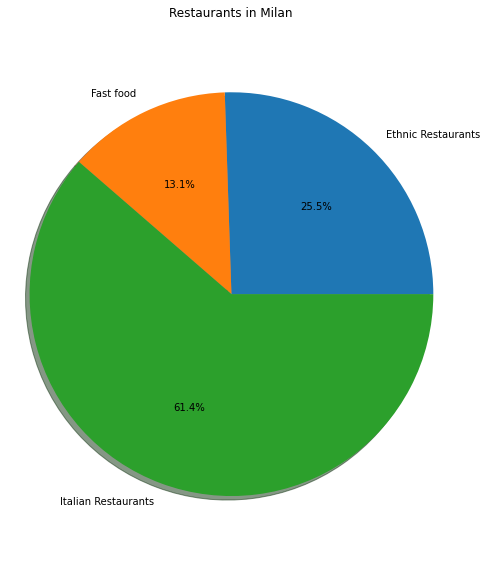

In [14]:

pie.plot(kind='pie',
                            figsize=(8, 10),
                            autopct='%1.1f%%', # add in percentages
                            startangle=0,     # start angle 
                            shadow=True,       # add shadow  
                        
                            )

plt.title('Restaurants in Milan')
plt.axis('equal') # Sets the pie chart to look like a circle.
plt.axes().set_ylabel('')
plt.show()

In [15]:
ethnic_restaurants = neighborhood_restaurants[~neighborhood_restaurants['VenueCategory'].isin(list_of_italian_restaurants)]
ethnic_restaurants.drop(ethnic_restaurants[ethnic_restaurants.VenueCategory.isin(list_of_non_ethnic)].index, inplace=True)
ethnic_restaurants.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
2,Affori,45.51410,9.17353,Istanbul Kebab,4d4b4693a154721e56ed6ecf,45.510421,9.176128,456,Kebab Restaurant
43,Baggio,45.46324,9.09270,Kazan Japanese Restaurant,4c377f61dfb0e21edde5aca8,45.461086,9.094075,262,Japanese Restaurant
102,Bicocca,45.52149,9.21326,Sushi 187,5570a4a5498eb7e4a1b05ce7,45.516212,9.208964,676,Sushi Restaurant
103,Bicocca,45.52149,9.21326,Istanbul Kebab Bicocca,4c18b308838020a1737be461,45.515589,9.211940,664,Kebab Restaurant
123,Bovisa,45.50313,9.16122,Sushi Ran,5b34bba156c89f002c5bab4c,45.500348,9.170942,819,Japanese Restaurant


In [16]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "Restaurant Count"})[['Restaurant Count']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'Restaurant Count': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)


In [17]:
# get counts of ethnic restaurants in each Neighborhood
df_eth_rest_counts =  ethnic_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "Ethnic Restaurant Count"})[['Ethnic Restaurant Count']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(ethnic_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_eth_rest_counts = df_eth_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'Ethnic Restaurant Count': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_eth_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_eth_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['Restaurant Count'],ascending =False)
df_rest_counts.head()


,Restaurant Count,Ethnic Restaurant Count
Neighborhood,,
Turro,55,18
Porta Volta,51,21
Portello,47,16
Porta Garibaldi,47,13
Porta Nuova,42,11


In [18]:
print('{} neighborhoods do not have any ethnic restaurant'.format(len(noRestList)))

21 neighborhoods do not have any ethnic restaurant


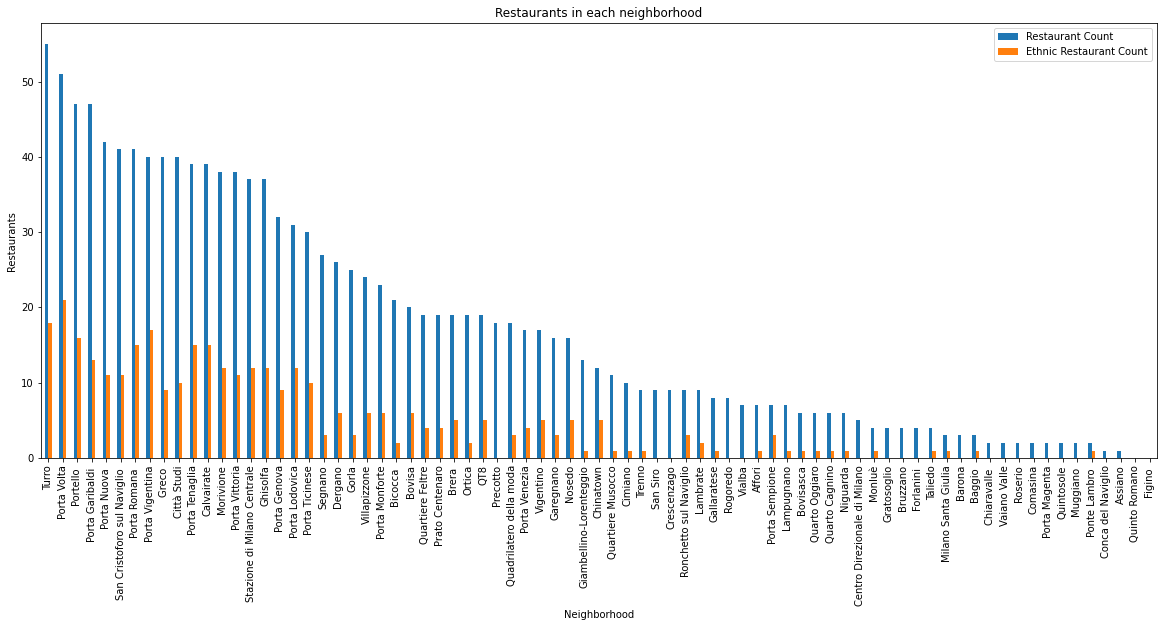

In [19]:
df_rest_counts[['Restaurant Count','Ethnic Restaurant Count']].plot(kind='bar',figsize=(20,8))
plt.title('Restaurants in each neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurants')
plt.show()

### Get ratings

In [20]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,4d95a5a4af3d236ae7b6f5c6,None,None
1,4d4b4693a154721e56ed6ecf,None,None
2,52ad9bd3498ea486e55afb24,None,None
3,509ab104e4b09409675587d7,None,None
4,4be4716ecf200f4727f8113c,None,None


In [21]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Affori,45.51410,9.17353,Al Paradiso Della Pizza,4d95a5a4af3d236ae7b6f5c6,45.511351,9.175416,339,Pizza Place,None,None
1,Dergano,45.50411,9.17647,Al Paradiso Della Pizza,4d95a5a4af3d236ae7b6f5c6,45.511351,9.175416,810,Pizza Place,None,None
2,Affori,45.51410,9.17353,Istanbul Kebab,4d4b4693a154721e56ed6ecf,45.510421,9.176128,456,Kebab Restaurant,None,None
3,Dergano,45.50411,9.17647,Istanbul Kebab,4d4b4693a154721e56ed6ecf,45.510421,9.176128,702,Kebab Restaurant,None,None
4,Affori,45.51410,9.17353,Osteria del Biliardo,52ad9bd3498ea486e55afb24,45.514812,9.169422,330,Italian Restaurant,None,None


In [22]:
#merge raitings to ethnic restaurants 
ethnic_restaurants = ethnic_restaurants.merge(restaurants_raitings)
ethnic_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Affori,45.51410,9.17353,Istanbul Kebab,4d4b4693a154721e56ed6ecf,45.510421,9.176128,456,Kebab Restaurant,None,None
1,Dergano,45.50411,9.17647,Istanbul Kebab,4d4b4693a154721e56ed6ecf,45.510421,9.176128,702,Kebab Restaurant,None,None
2,Baggio,45.46324,9.09270,Kazan Japanese Restaurant,4c377f61dfb0e21edde5aca8,45.461086,9.094075,262,Japanese Restaurant,None,None
3,Bicocca,45.52149,9.21326,Sushi 187,5570a4a5498eb7e4a1b05ce7,45.516212,9.208964,676,Sushi Restaurant,None,None
4,Bicocca,45.52149,9.21326,Istanbul Kebab Bicocca,4c18b308838020a1737be461,45.515589,9.211940,664,Kebab Restaurant,None,None


### Show restaurants on head map

Red markers are ethnic restaurants

Blue markers are ethnic restaurants with rating less than 8

In [23]:
milan_center = [latitude, longitude]
map_restaurant= folium.Map(location= milan_center, zoom_start=12)
df_neighborhood_no_eth_rest = neighborhood_restaurants[neighborhood_restaurants['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_restaurant) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(milan_center).add_to(map_restaurant)
folium.Circle(milan_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(ethnic_restaurants['VenueLatitude'], ethnic_restaurants['VenueLongitude'], ethnic_restaurants['Neighborhood'], ethnic_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
    
raiting_lt_8 = ethnic_restaurants[ethnic_restaurants['VenueRating'] <8]
for lat, lon, neig, name in zip(raiting_lt_8['VenueLatitude'], raiting_lt_8['VenueLongitude'], raiting_lt_8['Neighborhood'], raiting_lt_8['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant    

We can see there are not so many ethnic restaurants after 4 km to center or there are restaurants with not excellent ratings

###  neighborhoods with no ethnic restaurant on head map

In [35]:
milan_center = [latitude, longitude]
map_restaurant= folium.Map(location= milan_center, zoom_start=12)

df_neighborhood_no_eth_rest = neighborhood_restaurants[neighborhood_restaurants['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_restaurant) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(milan_center).add_to(map_restaurant)
folium.Circle(milan_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_no_eth_rest['Latitude'], df_neighborhood_no_eth_rest['Longitude'], df_neighborhood_no_eth_rest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

# Cluster Neigborhoods 

In [25]:
# one hot encoding
venues_onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Yoga Studio,Abruzzo Restaurant,Accessories Store,Adult Education Center,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Argentinian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Volleyball Court,Warehouse Store,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped.head()

,Neighborhood,Yoga Studio,Abruzzo Restaurant,Accessories Store,Adult Education Center,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,...,Vegetarian / Vegan Restaurant,Video Game Store,Volleyball Court,Warehouse Store,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,Affori,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Assiano,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Baggio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Barona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bicocca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check the 10 most common venues in each neighborhood.

In [27]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affori,Pizza Place,Hotel,Café,Park,Rock Club,Cocktail Bar,Soccer Field,Nightclub,Shipping Store,Brewery
1,Assiano,Mediterranean Restaurant,Airport,Soccer Field,Juice Bar,Women's Store,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
2,Baggio,Café,Supermarket,Park,Cupcake Shop,Plaza,Bus Station,Gastropub,Pizza Place,Bar,Japanese Restaurant
3,Barona,Soccer Field,Café,Supermarket,Rock Club,Athletics & Sports,Theater,Trattoria/Osteria,Tennis Stadium,Gastropub,Bus Stop
4,Bicocca,Café,Italian Restaurant,Pizza Place,Sandwich Place,Restaurant,Theater,Piadineria,Plaza,Ice Cream Shop,Sardinian Restaurant


In [28]:
# set number of clusters
kclusters = 4

venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([1, 0, 1, 1, 2, 2, 1, 2, 2, 2], dtype=int32)

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

milan_merged = df_neighborhoods

# merge toronto_grouped with milan_data to add latitude/longitude for each neighborhood
milan_merged = milan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

milan_merged.head() 

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affori,45.514100,9.173530,1,Pizza Place,Hotel,Café,Park,Rock Club,Cocktail Bar,Soccer Field,Nightclub,Shipping Store,Brewery
1,Assiano,45.450605,9.061639,0,Mediterranean Restaurant,Airport,Soccer Field,Juice Bar,Women's Store,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
2,Baggio,45.463240,9.092700,1,Café,Supermarket,Park,Cupcake Shop,Plaza,Bus Station,Gastropub,Pizza Place,Bar,Japanese Restaurant
3,Barona,45.433710,9.151600,1,Soccer Field,Café,Supermarket,Rock Club,Athletics & Sports,Theater,Trattoria/Osteria,Tennis Stadium,Gastropub,Bus Stop
4,Bicocca,45.521490,9.213260,2,Café,Italian Restaurant,Pizza Place,Sandwich Place,Restaurant,Theater,Piadineria,Plaza,Ice Cream Shop,Sardinian Restaurant


In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        milan_merged['Latitude'], 
        milan_merged['Longitude'], 
        milan_merged['Neighborhood'], 
        milan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### cluster 1

In [31]:
milan_merged.loc[milan_merged['Cluster Labels'] == 0, milan_merged.columns[[0] + list(range(3, milan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Assiano,0,Mediterranean Restaurant,Airport,Soccer Field,Juice Bar,Women's Store,Flower Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
33,Muggiano,0,Restaurant,Airport,Gas Station,Juice Bar,Snack Place,Mediterranean Restaurant,Soccer Field,Hotel Bar,Food Court,Food & Drink Shop


### cluster 2

In [32]:
milan_merged.loc[milan_merged['Cluster Labels'] == 1, milan_merged.columns[[0] + list(range(3, milan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affori,1,Pizza Place,Hotel,Café,Park,Rock Club,Cocktail Bar,Soccer Field,Nightclub,Shipping Store,Brewery
2,Baggio,1,Café,Supermarket,Park,Cupcake Shop,Plaza,Bus Station,Gastropub,Pizza Place,Bar,Japanese Restaurant
3,Barona,1,Soccer Field,Café,Supermarket,Rock Club,Athletics & Sports,Theater,Trattoria/Osteria,Tennis Stadium,Gastropub,Bus Stop
6,Bovisasca,1,Clothing Store,Supermarket,Soccer Field,Pizza Place,Bus Stop,Park,Italian Restaurant,Shoe Store,Fast Food Restaurant,Bookstore
11,Chiaravalle,1,Café,Italian Restaurant,Restaurant,General Entertainment,Women's Store,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market
13,Cimiano,1,Café,Italian Restaurant,Pizza Place,Soccer Field,Hotel,Pharmacy,Gym,Asian Restaurant,Outlet Mall,Trattoria/Osteria
15,Comasina,1,Soccer Field,Bus Station,Gym Pool,Café,Fast Food Restaurant,Supermarket,General Entertainment,Metro Station,Bakery,Clothing Store
17,Crescenzago,1,Café,Italian Restaurant,Pizza Place,Park,Hostel,Pharmacy,Soccer Field,Bus Stop,Furniture / Home Store,Supermarket
19,Figino,1,Stadium,Park,Volleyball Court,Café,Women's Store,Flea Market,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
21,Gallaratese,1,Café,Fast Food Restaurant,Pizza Place,Supermarket,Gym,Pool,Diner,Soccer Field,Seafood Restaurant,Sports Club


### cluster 3

In [33]:
milan_merged.loc[milan_merged['Cluster Labels'] == 2, milan_merged.columns[[0] + list(range(3, milan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bicocca,2,Café,Italian Restaurant,Pizza Place,Sandwich Place,Restaurant,Theater,Piadineria,Plaza,Ice Cream Shop,Sardinian Restaurant
5,Bovisa,2,Café,Italian Restaurant,Pizza Place,Japanese Restaurant,Supermarket,Ice Cream Shop,Platform,Piadineria,Bookstore,Boutique
7,Brera,2,Hotel,Ice Cream Shop,Boutique,Italian Restaurant,Plaza,Dessert Shop,Japanese Restaurant,Men's Store,Bakery,Restaurant
8,Bruzzano,2,Bus Station,Italian Restaurant,Ice Cream Shop,Pizza Place,Theater,Football Stadium,Bakery,Gym / Fitness Center,Train Station,Shopping Mall
9,Calvairate,2,Italian Restaurant,Pizza Place,Tram Station,Café,Supermarket,Sushi Restaurant,Park,Plaza,Theater,Asian Restaurant
10,Centro Direzionale di Milano,2,Italian Restaurant,Hotel,Café,Fast Food Restaurant,Convenience Store,Cafeteria,Rest Area,Bakery,Light Rail Station,Outdoors & Recreation
12,Chinatown,2,Pizza Place,Bakery,Chinese Restaurant,Ice Cream Shop,Sushi Restaurant,Supermarket,Clothing Store,Café,Italian Restaurant,Seafood Restaurant
14,Città Studi,2,Pizza Place,Dessert Shop,Ice Cream Shop,Italian Restaurant,Café,Restaurant,Seafood Restaurant,Hotel,Pub,Cocktail Bar
16,Conca del Naviglio,2,Fruit & Vegetable Store,Toll Plaza,Mediterranean Restaurant,Bus Station,Athletics & Sports,Gourmet Shop,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant
18,Dergano,2,Pizza Place,Café,Hotel,Italian Restaurant,Supermarket,Plaza,Diner,Bookstore,Park,Ice Cream Shop


### cluster 4

In [34]:
milan_merged.loc[milan_merged['Cluster Labels'] == 3, milan_merged.columns[[0] + list(range(3, milan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Quintosole,3,Italian Restaurant,Flower Shop,Hotel,Women's Store,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market
